# Dishonest Casino


Motivated by: https://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_casino_example.html

## The Story

A dishonest casino occassionally swaps their dice (fair <-> biased), but all we see is a sequence $X$ of throws $X \in \{0,1,2,3,4,5\}$.

In this part we will:

1. Be the casino: generate/sample such HMM data
2. Be a clever player: learn the parameters (transition rates, emission rates) from observations
3. try to decode the game: predict the most likely sequence of states

... all of this with hmmlearn.

## The HMM formulation

- States $Z$: { 0 = fair, 1 = biased }; 
- Observations $X$: { 0, 1, 2, 3, 4, 5 }
- Parameters $\Theta$:

\begin{align}
    P(Z_0) &= \begin{bmatrix} 0.5 & 0.5  \end{bmatrix} \\ \\
    P(Z_t | Z_{t-1}) & = \begin{bmatrix} 0.95 & 0.05 \\ 0.25 & 0.75 \end{bmatrix} \\ \\
    P(X_t | Z_t) & =  \begin{bmatrix} 1/6 & 1/6 &  1/6 & 1/6 & 1/6 & 1/6 \\ 0.1 & 0.1 & 0.1 & 0.1 & 0.1 & 0.5 \end{bmatrix} \\
\end{align}


## Setting up the Software

In [ ]:
%%script echo install only once
!pip install hmmlearn

install only once


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

## Playing the Casino: Generating states and observations

In [4]:
pf = [1./6 ] *6           # fair emission probabilities
pb = [1./10] *5 + [1/2]   # biased emission probabilities

np.random.seed(42)
model_gen = hmm.MultinomialHMM(n_components=2)

# set parameters
model_gen.startprob_ = np.array([0.5, 0.5])                     # initial state prob
model_gen.transmat_  = np.array([[0.95, 0.05], [0.25, 0.75]])   # transition prob
model_gen.emissionprob_ =  np.array([pf, pb])                   # emission prob

X,Z = model_gen.sample(5000)

**Task**: Inspect the shapes for X and Z.

In [5]:
print(np.shape(X))
print(np.shape(Z))

(5000, 1)
(5000,)


### Inspection: Does the generator work?

Here is a simple function to plot the distribution of the obserrvations for the different states.

Z:  0000000000000000011100000111000000000000000000000000000000000000000000111100011000000000000000000000
X:  5305451131024301550425331555111234514400301324322033140045135025312145230511225433513011200533153254


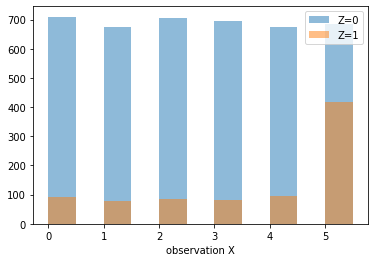

In [6]:
def HMM_inspect(Z,X,t=50):
  z_str = ''.join(str(z) for z in Z.flatten()[0:t])
  x_str = ''.join(str(x) for x in X.flatten()[0:t])
  print('Z: ',z_str)
  print('X: ',x_str)

  bs=list(np.arange(0,6,0.5))
  plt.hist(X[Z == 0], label='Z=0', alpha=0.5, bins=bs)
  plt.hist(X[Z == 1], label='Z=1', alpha=0.5, bins=bs)
  plt.xlabel('observation X')
  plt.legend()
  plt.show()

HMM_inspect(Z,X,100)

**Task (5 min)**: Understand and interprete the results.

## Fit the data

**Task (15 min)**

1. Use the Baum-Welch algorithm to fit a model with two states ("components"), given observations $X$.
2. Obtain the score for this fit: $\log P(X)$
3. Predict the best possible path $Z$

score:  -8894.804242228523
[[0.68955406 0.31044594]
 [0.42243335 0.57756665]]
----
[[0.23282005 0.11701354 0.19456236 0.21841664 0.18369127 0.05349614]
 [0.06143993 0.1962761  0.10969278 0.06970015 0.11409317 0.44879787]]
inspect
Z:  00000000000000000000000000000000000000000000000000
X:  53054511310243015504253315551112345144003013243220


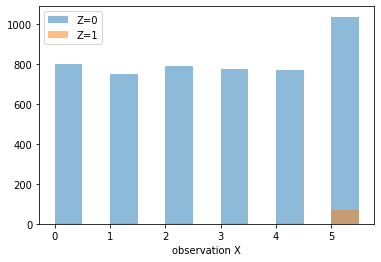

compare


NameError: name 'compareHMM' is not defined

In [7]:
#%%script echo edit before execution
np.random.seed(42)
model_fit = hmm.MultinomialHMM(n_components=2, n_iter=1000000)
model_fit.fit(X)
score = model_fit.score(X)
print('score: ', score)


print(model_fit.transmat_)
print('----')
print(model_fit.emissionprob_)

#predict best path
_, Zv = model_gen.decode(X, algorithm='viterbi')

print('inspect')
HMM_inspect(Zv, X)

print('compare')
compareHMM(model_gen, model_fit)

**Task & Discussion (5 min):** 

Was the fit successful - does it reflect our expectation? 

Remove np.random.seed() and run the above code cell multiple times. What's your conclusion?


**Group Task & Explorations (45 min):**

How could we improve the learning? 

Notice that there are many default parameters that can be adjusted. Consult the help pages for MultinomialHMM()!

- how many iterations are run by default? try to increase it.
- initialize parameters: maybe you can make an informed initial guess for the transitions probabilities
- loop over different initializations and keep only the model with best score
- would it help to use another choice for path predcition (decoding) ?
- If you have more time: you might want to generate longer sequences.


Z:  00000000000000000000000000000000000000000000000000
X:  53054511310243015504253315551112345144003013243220


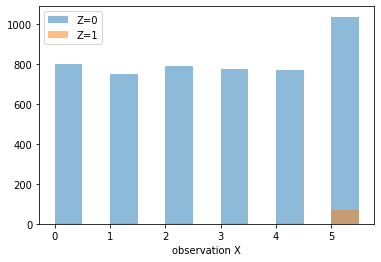

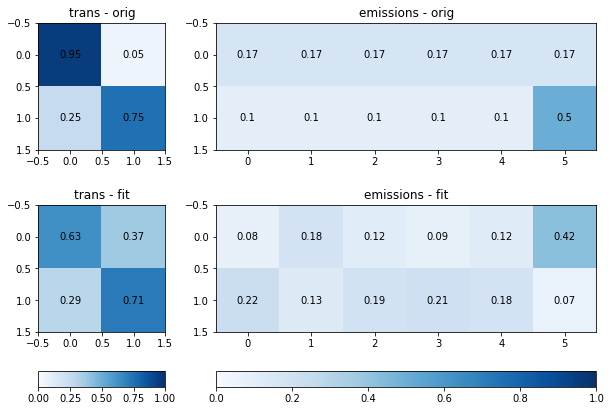

In [26]:
best_score = -1e81 # something really small
best_model = None

N_ini = 1
N_iter = 1000
P_assumed = np.array([ [0.9, 0.1],
                       [0.1, 0.9] ])

for i in range(30):
    curr_model = hmm.MultinomialHMM(n_components=2, n_iter=1000) #, init_params='ste') # as a default it randomizes all matrices
    # if we set init_params to 'se' we can now use:
    # curr_model.transmat_ = P_assumed # to set where to start the search for the transitin matrix
    #curr_model.transmat_ = P_assumed

    curr_model.fit(X)
    curr_score = curr_model.score(X)
    if curr_score > best_score:
        best_score = curr_score
        best_model = curr_model

HMM_inspect(Zv,X)
compareHMM(model_gen, best_model)

curr_model.monitor_

## Inspections

Here I provide some convenience function to compare the HMM parameters ($P$ and $E$) for two different models - for example the generating model and the fitted model.

In [16]:
# some convenience functions
from matplotlib.colors import Normalize

# plot matrix (with title and numbers)
def plotMatrix(ax, mat, title, cm, normalizer):
  ax.imshow(mat, cmap=cm, norm=normalizer)
  for (j,i),label in np.ndenumerate(mat):
    ax.text(i,j,np.round(label,2),ha='center',va='center')
    ax.set_title(title)

# compare two models
def compareHMM(model, model_fit):
  ## Visualization ###
  my_cm=plt.cm.Blues        # set color-map
  normalizer=Normalize(0,1) # set common color code for trans and emission probs 

  fig, ax = plt.subplots(3, 2, 
      gridspec_kw={'width_ratios': [1, 3], 'height_ratios': [1, 1, 0.1]},
      figsize=(10,7))

  plotMatrix(ax[0,0], model.transmat_, 'trans - orig', my_cm, normalizer)
  plotMatrix(ax[0,1], model.emissionprob_, 'emissions - orig', my_cm, normalizer)
  plotMatrix(ax[1,0], model_fit.transmat_, 'trans - fit', my_cm, normalizer)
  plotMatrix(ax[1,1], model_fit.emissionprob_, 'emissions - fit', my_cm, normalizer)

  # add colorbar with common color scale (set by im)
  im = plt.cm.ScalarMappable( cmap=my_cm, norm=normalizer) 
  fig.colorbar(im, cax=ax[2,0], orientation='horizontal')
  fig.colorbar(im, cax=ax[2,1], orientation='horizontal')
  plt.show()

In [ ]:
compareHMM(model_gen, best_model)

In [ ]:
#%%script echo alternative representation of emission probabilities
import pandas as pd
pp=pd.DataFrame(best_model.emissionprob_).plot(kind='bar', stacked=True, title='emissions')

**Messages:**

- Learning = Fitting is computationally the most demanding step
- The Baum-Welch Algorithm only delivers local maxima - run it several times to explore other initial conditions
- Be aware of **hyperparameters** that may need fine-tuning: number of iterations, initial estimates and prior assumptions
- The number of components needs to be chosen wisely (limits of unsupervised learning, c.f. k-means)
- More data helps, but fitting will take longer
- The state labels may swap


## Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

Z_pred = best_model.predict(X)
print('Z - orig: ', *Z[0:50])
print('Z - pred: ', *Z_pred[0:50])
print('confusion matrix: \n', confusion_matrix(Z, Z_pred))

**Task (10 min):**

Predict the path using the original (generative) model, and compare it with the path that was actually generated along with the observations. 

In [ ]:
_,Z_pred = model_gen.decode(X)
print('Z - orig: ', *Z[0:50])
print('Z - pred: ', *Z_pred[0:50])
print('confusion matrix: \n', confusion_matrix(Z, Z_pred))

**Message:** 

Although state transitions and emission probabilities may be predicted quite accurately, predicting the correct state path is much harder.

Even using the true original model, the predicted path $Z$ (the most likely path) is not necessarily the same that really gave rise to the observation $X$